In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
image_path = "/content/drive/MyDrive/Colab Notebooks/CFL_training_data"

Input and Output Images

In [10]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(image_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

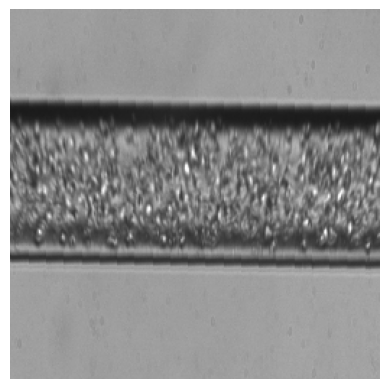

(256, 256, 3)


In [11]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

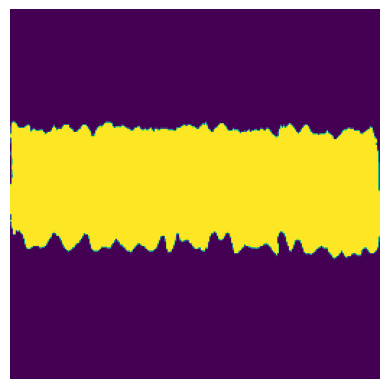

(256, 256, 1)


In [12]:
plt.imshow(output_images[1]*255)
plt.axis('off')
plt.show()
print(output_images[1].shape)

U-Net++ Model Training and Fitting

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def unet_plus_plus(input_shape=(256, 256, 3), num_filters=64):
    inputs = Input(input_shape)

    # Downsampling
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv_block(p4, num_filters * 16)

    # Upsampling
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = conv_block(u9, num_filters)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    #model = Model(inputs=[inputs], outputs=[outputs], name = "U-Net++")
    model = Model(inputs=[inputs], outputs=[outputs], name="U_Net_Plus_Plus")


    return model


In [ ]:
model = unet_plus_plus()
model.summary()

In [7]:
import keras.backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01 * tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])
#model.compile(optimizer=Adam(lr=1e-4), loss=dice_p_bce, metrics=['accuracy', dice_coef, mean_iou])

In [ ]:
checkpoint_filepath = os.path.join(image_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Saving Model

In [ ]:
model.save(os.path.join(image_path, 'unet_plus_plus_40_epochs.hdf5'))

Loading Model

In [8]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/unet_plus_plus_40_epochs.hdf5"


model = load_model(model_path, custom_objects={'dice_coef': dice_coef, 'true_positive_rate': true_positive_rate})

In [15]:
np.array(input_images[:5]).shape

(5, 256, 256, 3)

In [21]:
import numpy as np

def dice_coefficient(output_image, predicted_image):
    # Binarize images
    output_image = np.array(output_image) > 0.5  # Assuming output_image is normalized (0 to 1)
    predicted_image = np.array(predicted_image) > 0.5  # Use the same threshold as used in plotting

    # Flatten the arrays to 1D
    output_array_flat = output_image.flatten()
    predicted_array_flat = predicted_image.flatten()

    # Calculate intersection and union
    intersection = np.sum(output_array_flat * predicted_array_flat)
    union = np.sum(output_array_flat) + np.sum(predicted_array_flat)

    # Calculate Dice coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)  # Adding a small value to avoid division by zero
    return dice


Training Data Results

In [17]:
# Predicting on the first 5 images
pred = model.predict(np.array(input_images[:5]))

1/1 [==============================] - 8s 8s/step


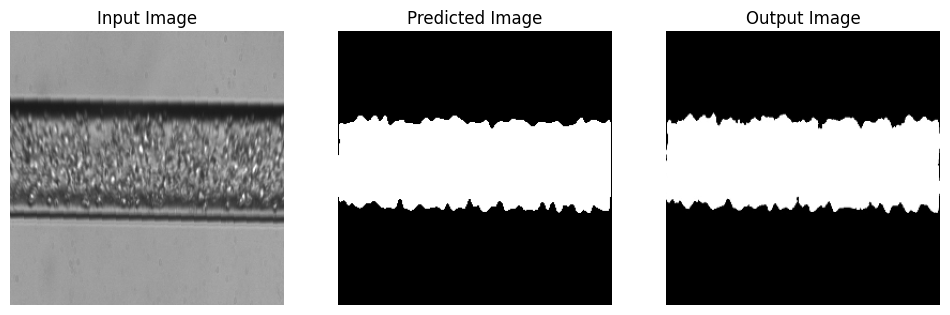

Dice Coefficient: 0.9837504219143279


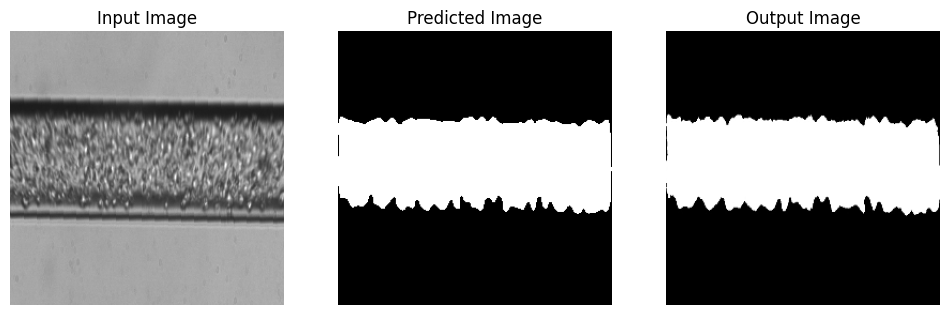

Dice Coefficient: 0.9855353378757213


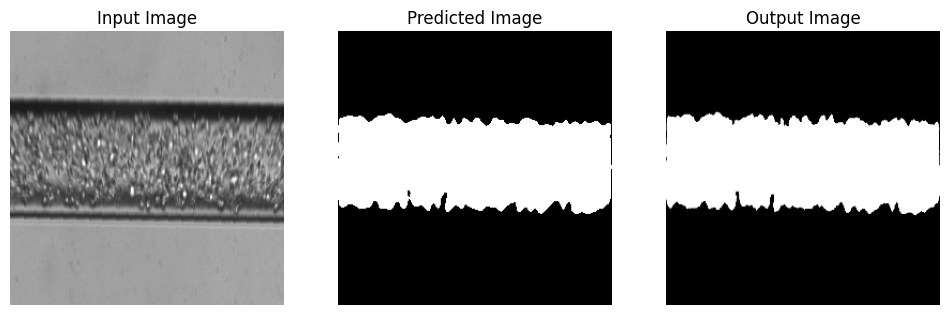

Dice Coefficient: 0.9863448864476921


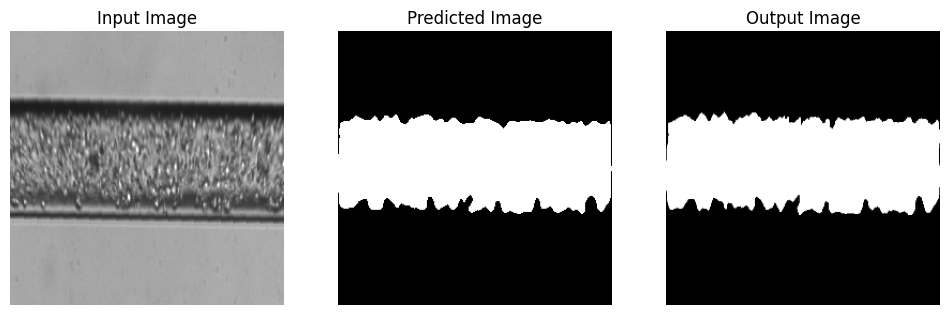

Dice Coefficient: 0.9846058526392608


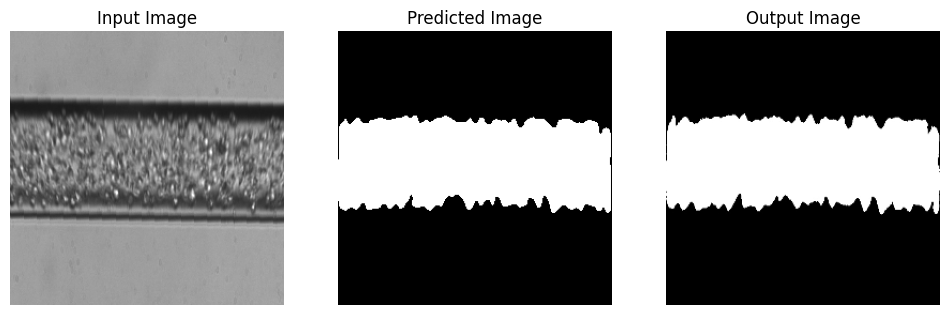

Dice Coefficient: 0.9838957992268283


In [22]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_images[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(output_images[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()

    # Calculate the Dice coefficient
    dice_score = dice_coefficient(output_images[i], pred[i])
    print("Dice Coefficient:", dice_score)


Validation Data Results

In [26]:
# Calculate the index for the validation split
validation_split = 0.2
split_index = int(len(input_images) * (1 - validation_split))

val_input_images = input_images[split_index:split_index + 5]
val_output_images = output_images[split_index:split_index + 5]

val_input = np.array(val_input_images)
val_output = np.array(val_output_images)

val_pred = model.predict(val_input)

1/1 [==============================] - 7s 7s/step


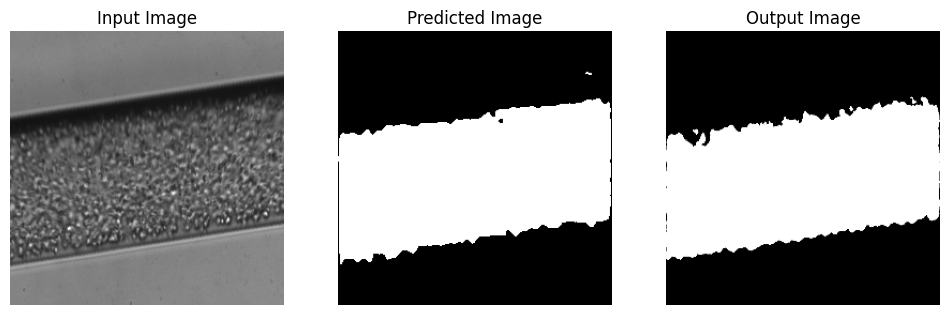

Dice Coefficient: 0.9705575419618228


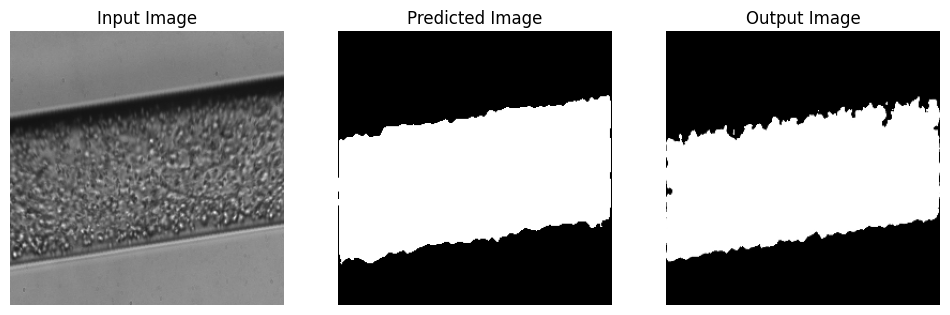

Dice Coefficient: 0.9658377636827581


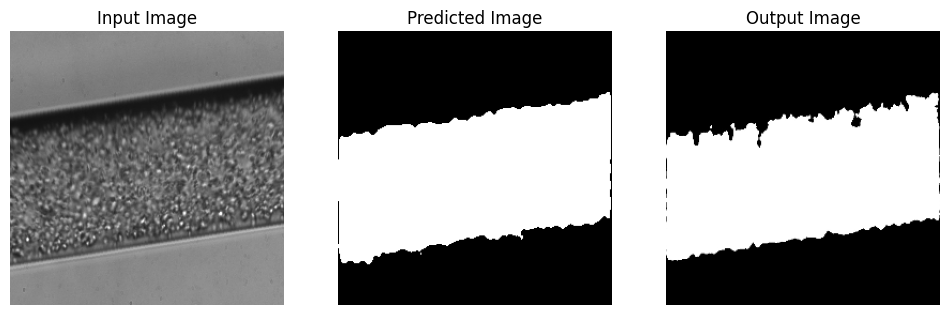

Dice Coefficient: 0.9670277266899946


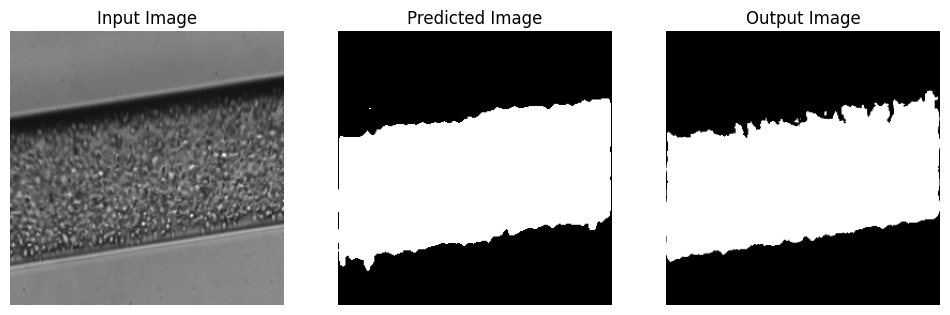

Dice Coefficient: 0.9672647956022588


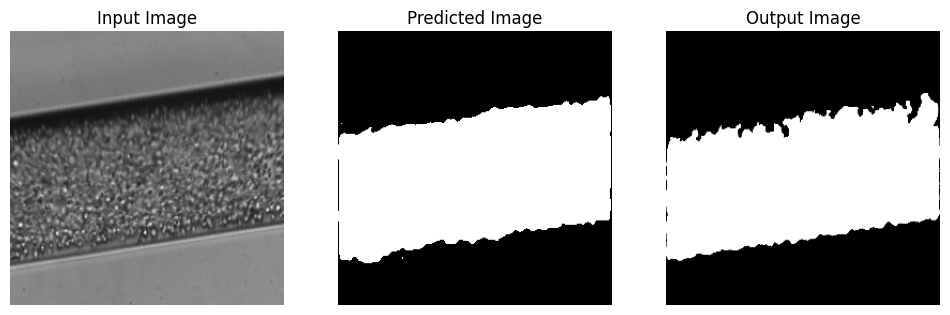

Dice Coefficient: 0.9633343028789614


In [27]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(val_input[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(val_pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(val_output[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()

    # Calculate the Dice coefficient
    dice_score = dice_coefficient(val_output[i], val_pred[i])
    print("Dice Coefficient:", dice_score)
